#  Introducing The "Morning Connectivity Score" of Bus Stops in Israel

In this work I use GTFS  data  to create a new measure of connectivity that may serve to rank bus stops. <br /> 
(up to date raw data can be found here ftp://199.203.58.18/) <br /> 
The idea is quite simple: a passenger is waiting at the (origin) bus stop at 7am. To how many other (destination) bus stops can he get by 8:00 with no more than two bus rides? The number of connected destination stops is the Morning Connectivity Score (MCS) of the origin bus stop.  <br /> 
A high MSC value suggest that a person that statrs his/her day next to that bus stop is more likely to be able to use public transportation conviniently.  <br /> 
Please note that a possible and natural development for this measure is to weigh each stop also by, for instance, the importance or attraction of the destination stops location. However, for simplicity, this time I consider a uniform weight across space and therefore a uniform weight for each destination stop.         

## Raw Data
The raw data include several tables.  <br /> 
I will load and briefly describe the relevant ones. 

### Stops file

In [24]:
import pandas as pd
import os
dirpath="C:/Research/Databases/PublicTransportation"
os.chdir(dirpath)
stops=pd.read_csv('stops.txt')
stops.shape
stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id
0,1,38831,בי''ס בר לב/בן יהודה,רחוב:בן יהודה 76 עיר: כפר סבא רציף: קומה:,32.183921,34.917806,0,NaN,6900
1,2,38832,הרצל/צומת בילו,רחוב:הרצל עיר: קרית עקרון רציף: קומה:,31.870034,34.819541,0,NaN,469
2,3,38833,הנחשול/הדייגים,רחוב:הנחשול 30 עיר: ראשון לציון רציף: קומה:,31.984553,34.782828,0,NaN,8300
3,4,38834,פריד/ששת הימים,רחוב:משה פריד 9 עיר: רחובות רציף: קומה:,31.888550,34.790904,0,NaN,8400
4,6,38836,ת. מרכזית לוד/הורדה,רחוב: עיר: לוד רציף: קומה:,31.956392,34.898098,0,NaN,7000


The "stops" file contains information about each stop. That includes also its coordinates, and its parent station (if exists).  <br /> 
The stop_code field stores the code that is writen on the bus stop sign; the stop_id field is used as a key to join the data to other tables.  

### Routes file

In [26]:
routes=pd.read_csv('routes.txt')
routes.shape
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color
0,1,25,1,ת. רכבת יבנה מערב-יבנה<->ת. רכבת יבנה מזרח-יבנ...,67001-1-#,3,NaN
1,2,25,1,ת. רכבת יבנה מזרח-יבנה<->ת. רכבת יבנה מערב-יבנ...,67001-2-#,3,NaN
2,3,25,2,ת. רכבת יבנה מערב-יבנה<->ת. רכבת יבנה מזרח-יבנ...,56002-1-#,3,NaN
3,5,25,2,ת. רכבת יבנה מזרח-יבנה<->ת. רכבת יבנה מערב-יבנ...,56002-2-#,3,NaN
4,7,25,3,ת. רכבת יבנה מערב-יבנה<->ת. רכבת יבנה מזרח-יבנ...,49003-1-#,3,NaN


The routes file holds information with regards to each route.
A specific bus line (say, "5") can have few alternative routes (different directions, routes alternatives for different hours etc.)  <br /> 
However, if for example the "5" of 6pm and the "5" of 7pm follow the same route they will share the route_id.
The route_short_name field is the bus line as can be seen by the bus riders.


### Trips file

In [29]:
trips=pd.read_csv('trips.txt')
trips.shape
trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,1,1,30900053_281120,רכבת יבנה מזרח,0,97105
1,1,1,30900054_281120,רכבת יבנה מזרח,0,97105
2,1,1,30900055_281120,רכבת יבנה מזרח,0,97105
3,1,1,30900056_281120,רכבת יבנה מזרח,0,97105
4,1,1,30900057_281120,רכבת יבנה מזרח,0,97105


Each planned service bus ride is considered as a trip. 
The "Trips" file assign each trip ('trip_id') to its route, and defines the headsign of the bus. 

### Stop_Times file

The "stop_times" file is a large file that lists the estimated time for each bus (trip) arriving to each bus stop. It is the core file for this exercise.   <br /> 
The drop_off/pickup_type fields provide further information for stops in which a bus on specific trip may stop by not allow either pick up of drop off. 

In [31]:
stop_times=pd.read_csv('stop_times.txt')
stop_times.shape
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled
0,10033656_281120,07:55:00,07:55:00,13345,1,0,1,0
1,10033656_281120,07:56:13,07:56:13,14043,2,0,1,346
2,10033656_281120,07:56:43,07:56:43,14356,3,0,1,567
3,10033656_281120,07:57:19,07:57:19,13338,4,0,1,723
4,10033656_281120,07:57:57,07:57:57,38713,5,0,1,920


## Data Manipulation and Measure Calculation

Since today I want to practice my SQL skills a bit, I mostly use sql queries in order to manipulate the data and calculate the MCS measure. 
The manipulation steps take include:  <br />  (1) join the relevant fields from different tables to a single table, and replace stop_id with parent stop_ids when possible  <br />  (2) find all possible bus-ride-links between bus stops between 7am and 8am.  <br />  (3) extract the earliest time for a passenger to arrive to each bus stop.  <br /> (4) find all other continuing bus ride alternatives at the remaining time until 8am.  <br />  (5) calculate the MCS measure. <br />
In order to make the process more clear (at least for me) I do it step-by-step rather than in a single long query.

In [33]:
import pandasql as psql
# Step 1
# Only 28/11/2020 data between 7am to 8am
stop_times_reduced=psql.sqldf("SELECT * FROM stop_times WHERE trip_id LIKE ('%281120') AND arrival_time>='07:00:00'  AND arrival_time<='08:00:00'")
#asigining parent station properities, when relevant
stops_new=psql.sqldf(""" SELECT *, CASE 
                     WHEN parent_station IS NOT NULL THEN parent_station
                     ELSE stop_id
                     END AS final_id FROM stops""")
stop_times_ready=psql.sqldf(""" SELECT a.trip_id, a.stop_id, stop_code, arrival_time, route_short_name, drop_off_type, pickup_type FROM stop_times_reduced a\
                 LEFT JOIN (SELECT * FROM trips \
                 JOIN routes ON trips.route_id = routes.route_id) b ON a.trip_id=b.trip_id\
                 LEFT JOIN stops_new c ON a.stop_id=c.final_id """)
#Step 2
#All possible bus-rid-links (single ride)

all_combos=  psql.sqldf(""" SELECT a.trip_id, a.stop_id AS stop_id_a, b.stop_id AS stop_id_b, a.stop_code AS stop_code_a, b.stop_code AS stop_code_b, a.arrival_time AS time_a, b.arrival_time AS time_b , a.route_short_name AS kav \
                        FROM stop_times_ready a JOIN stop_times_ready b ON (a.trip_id=b.trip_id) WHERE time_a<time_b AND a.pickup_type=0 AND b.drop_off_type=0""")

#Step 3
# Earliest time at each destination (after 1st bus ride)
min_time_combos=  psql.sqldf(""" SELECT stop_code_a, stop_code_b, MIN(time_b) AS time_b FROM all_combos GROUP BY stop_code_a, stop_code_b""") 


#Step 4
#add a second ride
min_time_combos2=  psql.sqldf(""" SELECT a.stop_code_a, c.stop_code_b AS stop_code_c, MIN(c.time_b) AS time_c \
                        FROM min_time_combos a JOIN all_combos c ON (a.stop_code_b=c.stop_code_a) WHERE (a.time_b<c.time_a) GROUP BY a.stop_code_a, stop_code_c""")

#Step 5
#Calculating the MCS
stops_score1=psql.sqldf(""" SELECT stop_code_a AS stop_code, COUNT(DISTINCT stop_code_b) AS score_1 FROM min_time_combos GROUP BY stop_code_a""")
stops_score2=psql.sqldf(""" SELECT stop_code_a AS stop_code, COUNT(DISTINCT stop_code_c) AS score_2 FROM min_time_combos2 GROUP BY stop_code_a""")
stops_scores=psql.sqldf("""SELECT a.stop_code, stop_name, stop_lat, stop_lon, score_1, score_2 FROM stops_score1 a JOIN stops_score2 b ON a.stop_code=b.stop_code LEFT JOIN stops ON a.stop_code=stops.stop_code""")

#save the results
#stops_scores[['stop_code','stop_name','score_2''stop_lat','stop_lon']].to_csv("BusStopsScore2.csv")
#stops_scores.to_csv("BusStopsScores.csv")
stops_scores.head()


KeyError: "['score_2stop_lat'] not in index"

In [34]:
stops_scores.head()

,stop_code,stop_name,stop_lat,stop_lon,score_1,score_2
0,1.0,יוסף קארו/בן איש חי,31.744547,35.000493,56,206
1,5.0,בן איש חי,31.748063,35.001105,41,213
2,15.0,אלזייתונה/אלאחתראם,31.840166,35.217048,8,6
3,27.0,אלמדינה אלמנורה/זעקוקה,31.737062,35.236670,27,146
4,28.0,אלמדינה אלמנורה/זעקוקה,31.737154,35.236632,6,28


## Spatial Visualization 

Due to the size of the data I was unable to plot the complete map inline. I therefore show the sample of bus stops in Binyamina (zone_id=9800) and Haifa (zone_id=4000). The complete map can be and list of score for each bus stop can be downloaded here [(map)](https://github.com/GolanR/Wix/blob/main/BusConnectivityScore.html) and [here (data)](https://github.com/GolanR/Wix/blob/main/BusStopsScores.csv).   

In [60]:
df=psql.sqldf("""SELECT a.stop_code, a.stop_name, a.stop_lat, a.stop_lon, a.score_1, a.score_2, b.zone_id FROM stops_scores a LEFT JOIN stops_new b ON a.stop_code=b.stop_code WHERE (b.zone_id=4000 OR b.zone_id=9800)""")

In [61]:
df.rename(columns={'stop_lat':'lat', 'stop_lon':'lng'}, inplace=True)
middle_lat = df['lat'].median()
middle_lon = df['lng'].median()

df['marker_color']='white'
df['marker_color'].loc[df.score_2>=50]='yellow'
df['marker_color'].loc[df.score_2>=100]='gold'
df['marker_color'].loc[df.score_2>=500]='orange'
df['marker_color'].loc[df.score_2>=1000]='red'


import folium
from folium import plugins
busConnectivity_map = folium.Map(location=[middle_lat, middle_lon], zoom_start=11, tiles='Stamen Toner')

# add points to map
for i in range(df.shape[0]):
    folium.CircleMarker([df.loc[i,'lat'], df.loc[i,'lng']],
                        radius=4,
                        popup="Morning Connectivity Score: "+str(df.loc[i,'score_2']),
                        color=df.loc[i,'marker_color'],
                        ).add_to(busConnectivity_map)

C:\Users\rgolan\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\rgolan\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\rgolan\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
busConnectivity_map

# Summary and some short analysis

In today's exercise I expolited GTFS data to introduce a new measure that quantifies connectivity level of bus stops. This measure can be used by planners that wish to compare connectivity across different location, to allocate limited resources to bus stops, or to individuals that, for example, want to take into account connectivity as they relocte under some level of uncertainty with regards to the destination of their future need to commute.  </br>
The results seems reasonable in the sense that bus stops at major traffic nodes recieve a higher score. Indication for reliability of the code.  </br>
Let's take a further inspect the data:  Haifa Vs. Binyamina by comparing the cdf (comulative distribution function) of the score whithin each city.


## CDF of the MCS: Haifa Vs Binyamina

In [56]:
stops_scores.to_csv("BusStopsScores.csv")

In [86]:
import numpy as np
haifa_scores=np.sort(df.score_2[df.zone_id==4000])
p_haifa=1/haifa_scores.shape[0]+np.arange(0,haifa_scores.shape[0])/haifa_scores.shape[0]

In [85]:
binyamina_scores=np.sort(df.score_2[df.zone_id==9800])
p_binyamina=1/binyamina_scores.shape[0]+np.arange(0,binyamina_scores.shape[0])/binyamina_scores.shape[0]

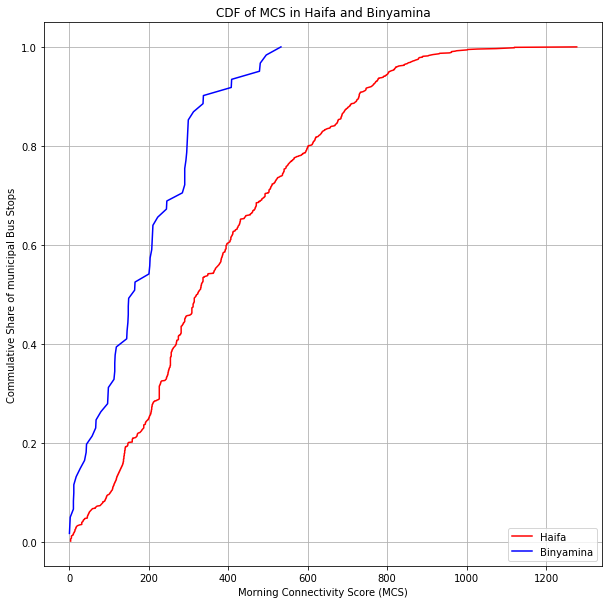

In [100]:
plt.figure(figsize=(10,10))
plt.plot(haifa_scores, p_haifa, 'r', label="Haifa") 
plt.plot(binyamina_scores,p_binyamina,'b', label="Binyamina")
plt.ylabel('Commulative Share of municipal Bus Stops')
plt.xlabel('Morning Connectivity Score (MCS)')
plt.title('CDF of MCS in Haifa and Binyamina')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()


Each point along the blue line in the plot above shows what share of the Binyamina's bus stops have an MSC of its x-axis value or less. Similarly with the red line and Haifa. </br>
As can be seen, and perhaps also assume in advence, Haifa provides a higher morning connectivity than Binyamina. 